<a href="https://colab.research.google.com/github/Auzek2002/Sign_Language_Detection_System/blob/main/Sign_Language_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libs:**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.layers import BatchNormalization
from zipfile import ZipFile
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import load_model

<ipython-input-1-a82a1852d649>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


# **Downloading the Data**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 97% 61.0M/62.6M [00:03<00:00, 24.2MB/s]
100% 62.6M/62.6M [00:03<00:00, 17.4MB/s]


# **Extracting the Data**

In [ ]:
file = "/content/sign-language-mnist.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Project Focus:**

## **Identifying Sign Language Letters:**

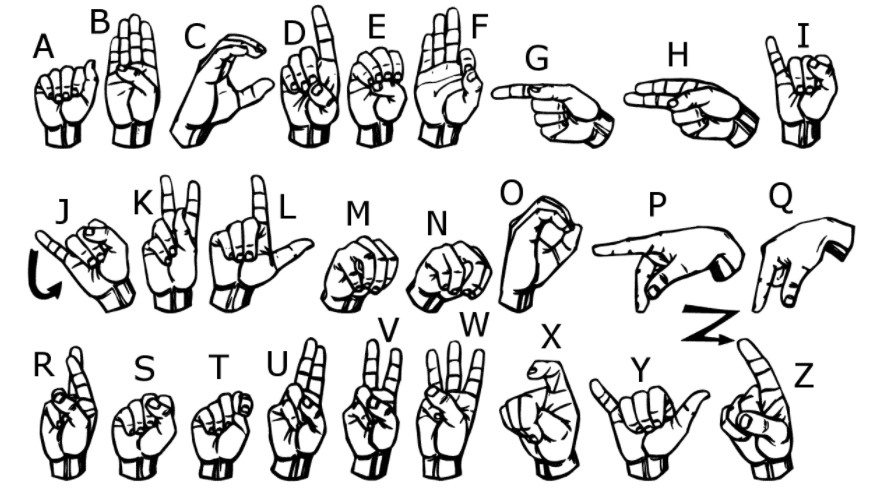

In [ ]:
ref_image = '/content/american_sign_language.PNG'
ref_image = cv2.imread(ref_image)
cv2_imshow(ref_image)

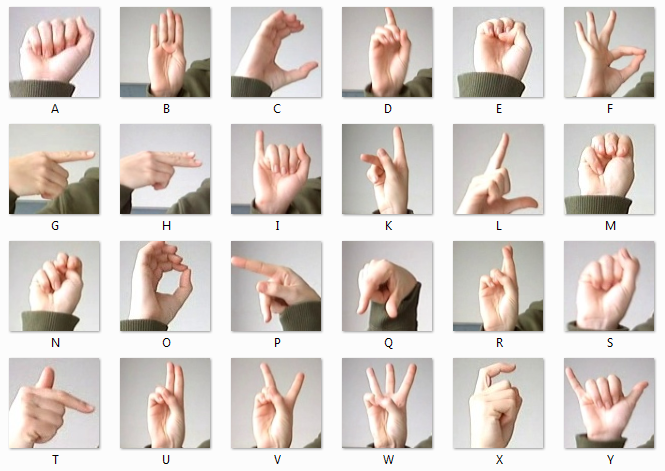

In [ ]:
ref_image2 = '/content/amer_sign2.png'
ref_image2 = cv2.imread(ref_image2)
cv2_imshow(ref_image2)

In [ ]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
print(train.shape)

(27455, 785)


In [ ]:
print(test.shape)

(7172, 785)


# **Preparing X_train, X_test, Y_train and Y_test**

In [ ]:
x_train = train.drop(['label'],axis=1)
y_train = train['label']
x_test = test.drop(['label'],axis=1)
y_test = test['label']

In [ ]:
print(f"shape of X_train: {x_train.shape}")
print(f"shape of Y_train: {y_train.shape}")
print(f"shape of X_test: {x_test.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (27455, 784)
shape of Y_train: (27455,)
shape of X_test: (7172, 784)
shape of y_test: (7172,)


# **One hot Encoding using LabelBinarizer:**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# **Normalizing the Images:**

In [ ]:
x_train , x_test = x_train/255.0 , x_test/255.0

# **Reshaping the Images:**

In [ ]:
x_train = x_train.values
x_test = x_test.values

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# **Displaying first 20 images:**

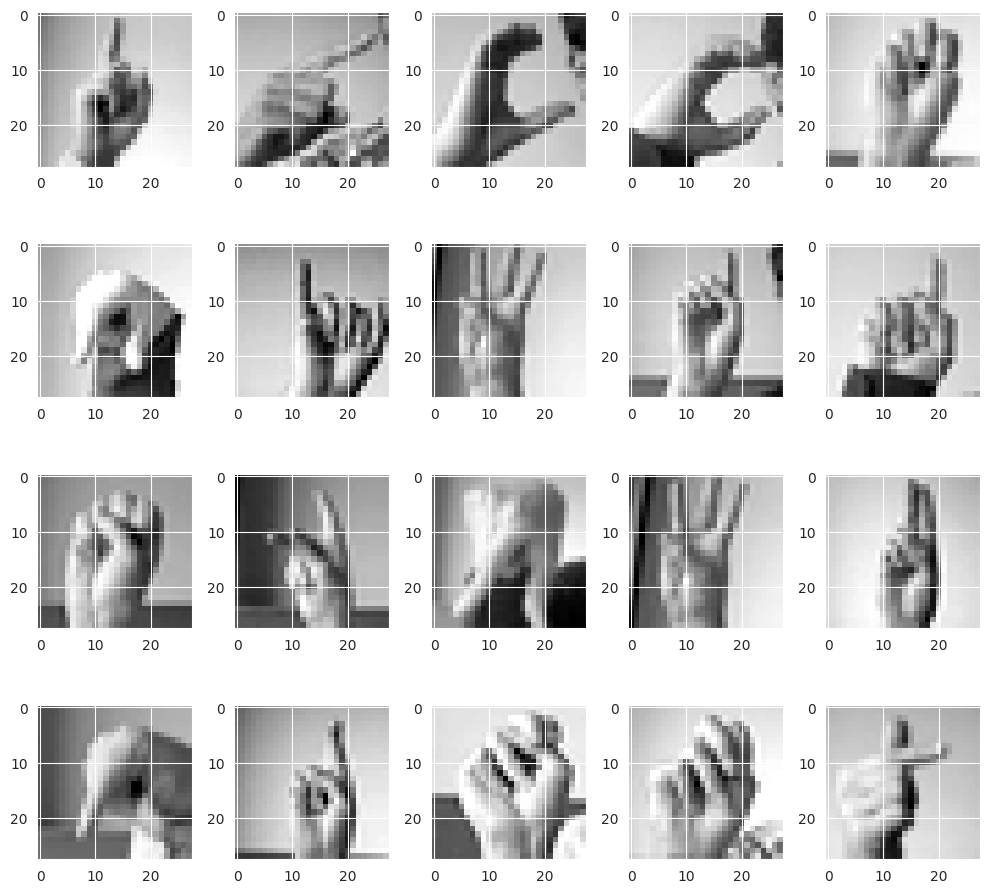

In [ ]:
fig, ax = plt.subplots(4,5)
fig.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

# **Building the Neural Network:**

In [ ]:
model = Sequential([
    Conv2D(75, (3,3), strides=1, padding='same', activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),

    Conv2D(50, (3,3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),

    Conv2D(25, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2, padding='same'),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(24, activation='softmax')
])

# **Network Structure:**

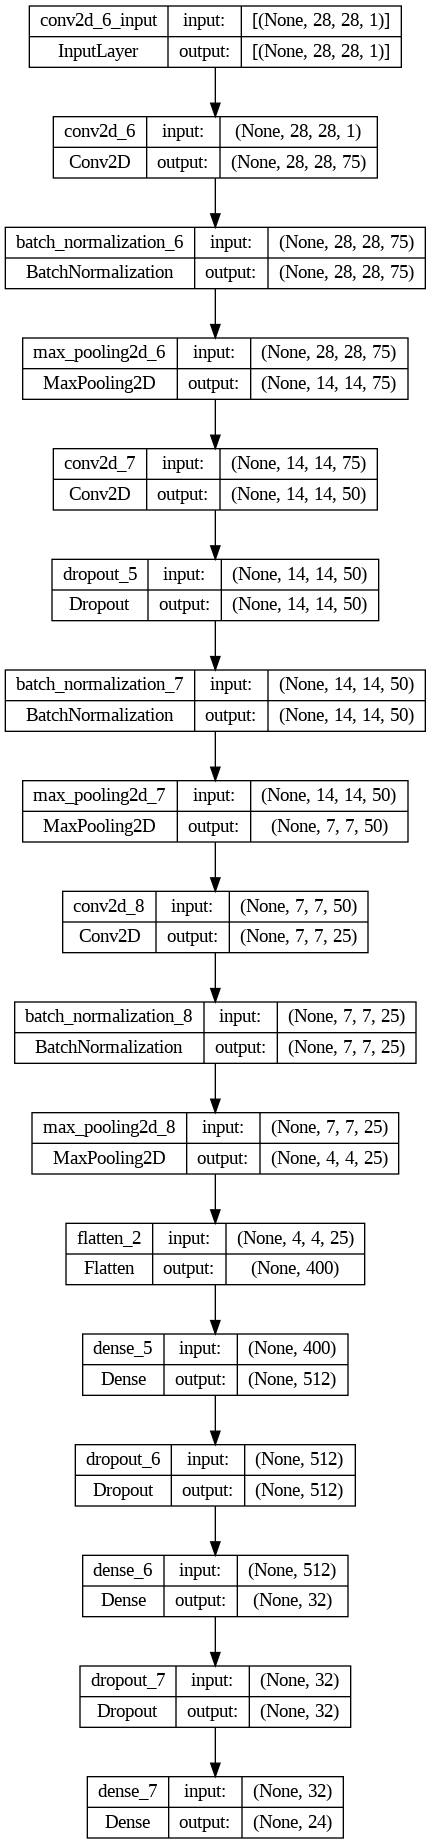

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Model Summary:**

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 50)       

# **Compiling the Model:**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics= ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,validation_split=0.1,epochs=15)

Epoch 1/15
773/773 [==============================] - 14s 7ms/step - loss: 2.4271 - accuracy: 0.2804 - val_loss: 1.3363 - val_accuracy: 0.7742
Epoch 2/15
773/773 [==============================] - 6s 8ms/step - loss: 1.0962 - accuracy: 0.6613 - val_loss: 0.3589 - val_accuracy: 0.9516
Epoch 3/15
773/773 [==============================] - 5s 6ms/step - loss: 0.5687 - accuracy: 0.8206 - val_loss: 0.1172 - val_accuracy: 0.9942
Epoch 4/15
773/773 [==============================] - 6s 8ms/step - loss: 0.3422 - accuracy: 0.8934 - val_loss: 0.0401 - val_accuracy: 0.9985
Epoch 5/15
773/773 [==============================] - 5s 7ms/step - loss: 0.2189 - accuracy: 0.9336 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 6/15
773/773 [==============================] - 5s 6ms/step - loss: 0.1536 - accuracy: 0.9546 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 7/15
773/773 [==============================] - 6s 8ms/step - loss: 0.1124 - accuracy: 0.9672 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch

# **Model Evaluation:**

In [ ]:
loss , acc = model.evaluate(x_test,y_test)
print(f'Accuracy on test data: {acc*100:.2f}%')

225/225 [==============================] - 2s 8ms/step - loss: 0.1178 - accuracy: 0.9643
Accuracy on test data: 96.43%


# **Plotting training loss vs val loss:**

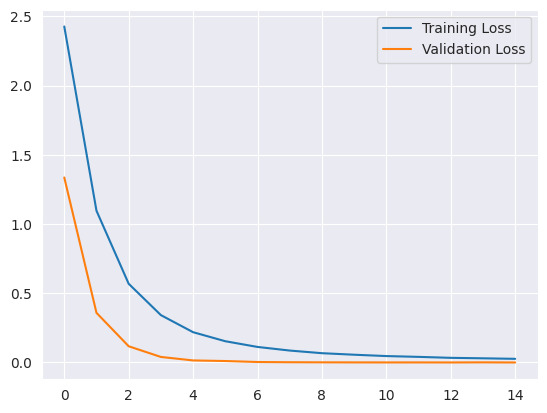

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

# **Plotting Training Acc vs val Acc:**

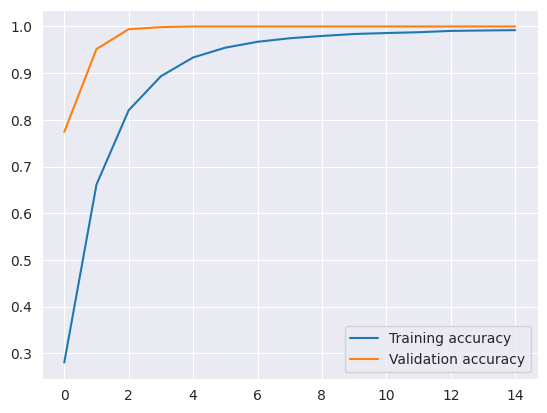

In [ ]:
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend()
plt.show()